In [5]:
import torch
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

dtype = torch.float

In [6]:
def norm_sigmoid(tensor):
    """maps real line to interval ]-1; 1[ """
    return 2*torch.sigmoid(tensor) - 1

In [7]:
# read in data
r_hat = torch.load('tensor_data/r_hat-torch.th')
s_hat = torch.load('tensor_data/s_hat-torch.th')
b = torch.load('tensor_data/b_DNS-torch.th')
grid = torch.load('tensor_data/grid-torch.th')

# N is batch size, D_in is input size, D_out is output size, H is hidden dimension
N = r_hat.shape[0]
D_in, D_out = 5, 10
H = 200

In [8]:
# initialize feature set (invariants)
inv = torch.zeros(N, 5, dtype=dtype, requires_grad=False) #

# compute feature set
inv[:,0] = torch.from_numpy(np.array(s_hat.matmul(s_hat)).trace(axis1=1, axis2=2))
inv[:,1] = torch.from_numpy(np.array(r_hat.matmul(r_hat)).trace(axis1=1, axis2=2))
inv[:,2] = torch.from_numpy(np.array(s_hat.matmul(s_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
inv[:,3] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
inv[:,4] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat)))).trace(axis1=1, axis2=2))

# normalize feature set
inv_scaled = norm_sigmoid(inv)
inv_scaled.requires_grad=True

#### Basis tensors:


\begin{align}
    T_1 &= \hat S \\
    T_2 &= \hat S \hat \Omega - \hat \Omega \hat S \\
    T_3 &= \hat S^2 - \frac{1}{3} \mathrm{tr} (\hat S^2)I \\
    T_4 &= \hat \Omega^2 - \frac{1}{3} \mathrm{tr} (\hat \Omega^2)I\\
    T_5 &= \hat \Omega \hat S^2 - \hat S^2 \Omega \\
    T_6 &= \hat \Omega^2 \hat S + \hat S \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S \hat \Omega^2)I \\
    T_7 &= \hat \Omega \hat S \hat \Omega^2 - \hat \Omega^2 \hat S \hat \Omega \\
    T_8 &= \hat S \hat \Omega \hat S^2 - \hat S^2 \hat \Omega \hat S \\
    T_9 &= \hat \Omega^2 \hat S^2 + \hat S^2 \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S^2 \hat \Omega^2)I \\
    T_{10} &= \hat \Omega \hat S^2 \hat \Omega^2 - \hat \Omega^2 \hat S^2 \hat \Omega
\end{align}

In [9]:
# initialize tensor basis
T = torch.zeros(N, 10, 9, dtype=dtype, requires_grad=False)

# compute tensor basis
T[:,0,:] = s_hat.flatten(1)  # s_hat
T[:,1,:] = (s_hat.matmul(r_hat) - r_hat.matmul(s_hat)).flatten(1)
T[:,2,:] = (s_hat.matmul(s_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
            inv[:,0].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,3,:] = (r_hat.matmul(r_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
            inv[:,1].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,4,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))).flatten(1)
T[:,5,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))
            - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,3].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,6,:] = (r_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat))) - r_hat.matmul(r_hat.matmul(s_hat.matmul(r_hat)))).flatten(1)
T[:,7,:] = (s_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) - s_hat.matmul(s_hat.matmul(r_hat.matmul(s_hat)))).flatten(1)
T[:,8,:] = (r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) + s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))
       - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,4].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,9,:] = (r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))) \
            - r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat))))).flatten(1)

# normalize tensor basis by spectral norm
for i in range(T.shape[1]):
    T[:,i,:] = T[:,i,:] / torch.tensor(la.norm(T[:,i,:].reshape(-1,3,3), ord=2, axis=(1,2))).unsqueeze(1).expand(N,9)

In [6]:
class TBNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TBNN, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden_layer_1 = torch.nn.Linear(H, H)
        self.hidden_layer_2 = torch.nn.Linear(H, H)
        self.hidden_layer_3 = torch.nn.Linear(H, 100)
        self.hidden_layer_4 = torch.nn.Linear(100, 50)
        self.hidden_layer_5 = torch.nn.Linear(50, 30)
        self.hidden_layer_6 = torch.nn.Linear(30, 20)
        self.output_linear = torch.nn.Linear(20, D_out)
        self.NN = torch.nn.Sequential(self.input_layer,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_1,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_2,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_3,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_4,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_5,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_6,
                                      torch.nn.LeakyReLU(),
                                      self.output_linear)
    def forward(self, inv, T):
        G = self.NN(inv).unsqueeze(2).expand(inv.shape[0],10,9)
        return (G*T).sum(dim=1)

In [7]:
model = TBNN(D_in, H, D_out)
loss_fn = torch.nn.MSELoss(reduction='sum')
y = b.flatten(1).clone().float()
y.requires_grad = False

## L2 regularization
lmbda = 1e-3 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

In [8]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
niters = 10000 # int(100/learning_rate)

In [9]:
for i in range(niters):
    # Forward pass
    y_pred = model(inv_scaled,T)
    
    # Compute and print loss
    loss = loss_fn(y_pred, y) # + L2loss(lmbda, model)
    if i % 1000 == 0:
        print(i, loss.item())
      
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 9079.224609375
1000 3514.43115234375
2000 3484.402587890625
3000 3448.375244140625
4000 3447.09912109375
5000 3408.260498046875
6000 3402.409912109375
7000 3390.63818359375
8000 3389.17529296875
9000 3387.493896484375


In [10]:
y_pred = model(inv_scaled,T)

In [11]:
# vizualize all components
grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]
grid_z1 = griddata(grid, y_pred.detach().numpy()[:,8], (grid_x, grid_y), method='linear')
grid_z2 = griddata(grid, y.detach().numpy()[:,8], (grid_x, grid_y), method='linear')

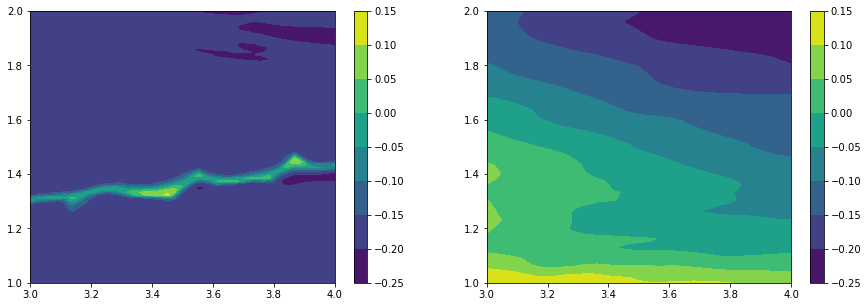

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
R_nn = ax[0].contourf(grid_x, grid_y, grid_z1)
R_dns = ax[1].contourf(grid_x, grid_y, grid_z2)
fig.colorbar(R_nn, ax=ax[0])
fig.colorbar(R_nn, ax=ax[1])

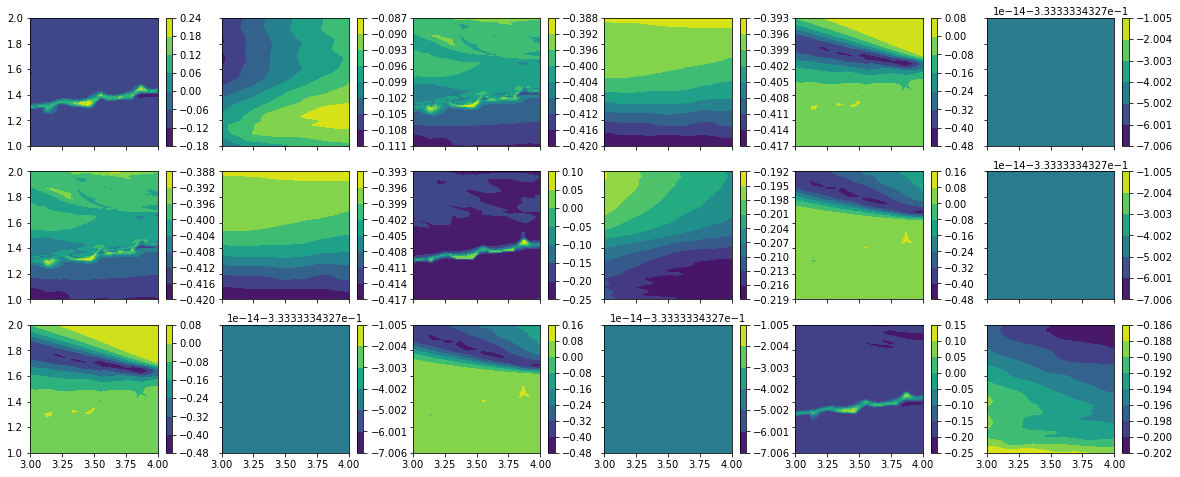

In [13]:
# visualize all tensor components
grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]
fig, axs = plt.subplots(3,6, figsize=(20,8), sharex=True, sharey=True)

for i in range(9):
    grid_z1 = griddata(grid, y_pred.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    grid_z2 = griddata(grid, y.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    R_nn = axs.flat[2*i].contourf(grid_x, grid_y, grid_z1)
    R_dns = axs.flat[2*i+1].contourf(grid_x, grid_y, grid_z2)
    fig.colorbar(R_nn, ax=axs.flat[2*i])
    fig.colorbar(R_dns, ax=axs.flat[2*i+1])